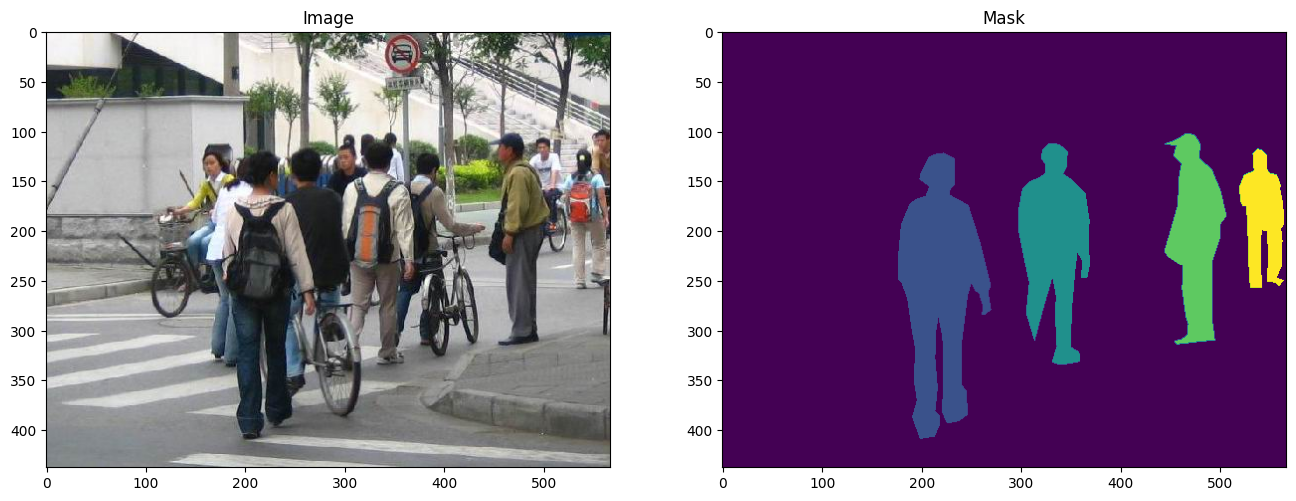

In [1]:
import matplotlib.pyplot as plt
from torchvision.io import  read_image

image = read_image('/data/yinxiaoln/datasets/data/PennFudanPed/PNGImages/FudanPed00046.png')
mask = read_image('/data/yinxiaoln/datasets/data/PennFudanPed/PedMasks/FudanPed00046_mask.png')
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title('Image')
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title('Mask')
plt.imshow(mask.permute(1, 2, 0))

In [11]:
import os
import torch

import torch.utils
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, 'PNGImages'))))
        self.masks = list(sorted(os.listdir(os.path.join(root, 'PedMasks'))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, 'PNGImages', self.imgs[idx])
        mask_path = os.path.join(self.root, 'PedMasks', self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        obj_ids = torch.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
        boxes = masks_to_boxes(masks)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        img = tv_tensors.Image(img)

        target = {}
        target['boxes'] = tv_tensors.BoundingBoxes(boxes, format='XYXY', canvas_size=F.get_size(img))
        target['masks'] = tv_tensors.Mask(masks)
        target['labels'] = labels
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        return img, target
    
    def __len__(self):
        return len(self.imgs)


In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [5]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

backbone = torchvision.models.mobilenet_v2(weights='DEFAULT').features
backbone.out_channels = 1280
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)    
)

roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2    
)

model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler        
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /home/yinxiaoln/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100.0%


In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes    
    )

    return model

In [7]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

--2024-06-22 22:55:03--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]
Saving to: ‘engine.py’

     0K ...                                                   100% 35.9M=0s

2024-06-22 22:55:35 (35.9 MB/s) - ‘engine.py’ saved [4063/4063]

--2024-06-22 22:55:35--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388 (8.2K) [text/plain]
Savin

0

In [8]:
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)


In [12]:
import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
dataset = PennFudanDataset('/data/yinxiaoln/datasets/data/PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)
print(output)

model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)
print(predictions[0])

{'loss_classifier': tensor(0.0718, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0403, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0147, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0019, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [18]:
from engine import train_one_epoch, evaluate

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
dataset = PennFudanDataset('/data/yinxiaoln/datasets/data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('/data/yinxiaoln/datasets/data/PennFudanPed', get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()
#dataset = torch.utils.data.Subset(dataset, indices[:-50])
#dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=utils.collate_fn    
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=2,
    shuffle=False,
    collate_fn=utils.collate_fn    
)

model = get_model_instance_segmentation(num_classes)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005  
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

num_epochs = 2

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [ 0/22]  eta: 0:00:16  lr: 0.000243  loss: 4.1466 (4.1466)  loss_classifier: 0.9004 (0.9004)  loss_box_reg: 0.2696 (0.2696)  loss_mask: 2.9559 (2.9559)  loss_objectness: 0.0169 (0.0169)  loss_rpn_box_reg: 0.0037 (0.0037)  time: 0.7377  data: 0.0759  max mem: 8907
Epoch: [0]  [10/22]  eta: 0:00:08  lr: 0.002621  loss: 1.3468 (1.9753)  loss_classifier: 0.2572 (0.4295)  loss_box_reg: 0.2696 (0.2654)  loss_mask: 0.7857 (1.2576)  loss_objectness: 0.0185 (0.0179)  loss_rpn_box_reg: 0.0050 (0.0050)  time: 0.7025  data: 0.0780  max mem: 10353
Epoch: [0]  [20/22]  eta: 0:00:01  lr: 0.005000  loss: 0.7162 (1.3427)  loss_classifier: 0.1909 (0.2897)  loss_box_reg: 0.2643 (0.2539)  loss_mask: 0.2771 (0.7775)  loss_objectness: 0.0147 (0.0151)  loss_rpn_box_reg: 0.0063 (0.0064)  time: 0.7125  data: 0.0777  max mem: 11939
Epoch: [0]  [21/22]  eta: 0:00:00  lr: 0.005000  loss: 0.7095 (1.2990)  loss_classifier: 0.1801 (0.2791)  loss_box_reg: 0.2643 (0.2478)  loss_mask: 0.2724 (0.7511)  loss_

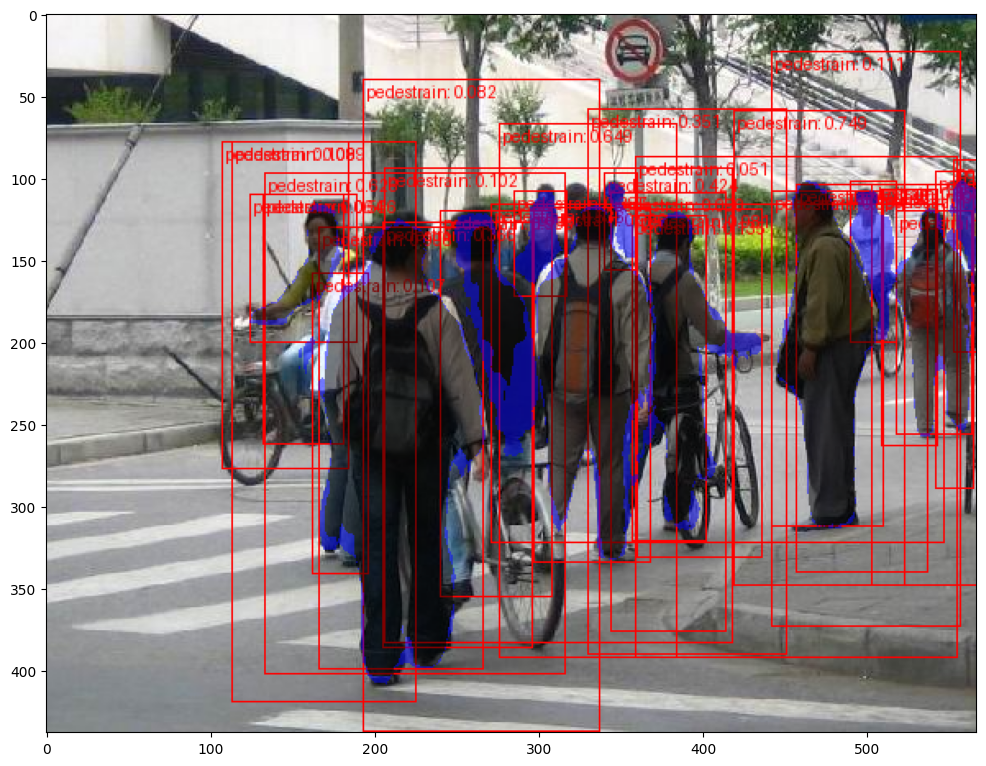

In [19]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image('/data/yinxiaoln/datasets/data/PennFudanPed/PNGImages/FudanPed00046.png')
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    x = x[:3, ...].to(device)
    predictions = model([x,])
    pred = predictions[0]

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f'pedestrain: {score:.3f}' for label, score in zip(pred['labels'], pred['scores'])]
pred_boxes = pred['boxes'].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors='red')

masks = (pred['masks'] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors='blue')

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))